Commençons par importer les données et les librairies nécessaires :

In [1]:
!pip install tensorflow==2.0.0b1


     |████████████████████████████████| 87.9MB 48kB/s 
     |████████████████████████████████| 501kB 44.0MB/s 
     |████████████████████████████████| 3.1MB 45.3MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
print(tf.__version__)

2.0.0-beta1


In [0]:
cryptos = ['ADA', 'BTC', 'LTC', 'EOS', 'ETH', 'BCH', 'BNB', 'BSV', 'USDT', 'XLM', 'XRP', 'XTZ']
link_root = 'https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/Crypto/'
end_file_name = '_data.csv'

# Création d'un dictionnaire qui va contenir les DataFrames de chaque Altcoin
dfs = {} 

for crypt in cryptos:
  file_link = link_root + crypt + end_file_name
  df = pd.read_csv(file_link, sep=';')
  dfs[crypt] = df

On définit la fonction qui convertit les données en numérique et en dates, puis on l'applique pour transformer les données :

In [0]:
def convert_to_numeric_and_date(df):
    num=['Open','High','Low','Close','Volume','Market Cap']

    for i in range(len(df)):
      for n in num:
        if type(df[n][i]) == str:
          df[n][i]=df[n][i].replace(',','')
          df[n][i]=pd.to_numeric(df[n][i])
          df[n][i] = np.float(df[n][i]) #convert numerical to integer in order to be able to apply statsmodels timeseries seasonal decompose

    try:
        df['Date'] = pd.to_datetime(df['Date'])
    except:
        pass
    return(df)

In [43]:
for crypt in cryptos:
  dfs[crypt] = convert_to_numeric_and_date(dfs[crypt])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


On commence une première analyse uniquement sur le BTC :

In [44]:
df_btc = dfs['BTC']
df_btc.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,bitcoin,2019-12-04,7320.13,7539.78,7170.92,7252.03,2.16642e+10,1.31143e+11
1,bitcoin,2019-12-03,7323.98,7418.86,7229.36,7320.15,1.47975e+10,1.3236e+11
2,bitcoin,2019-12-02,7424.04,7474.82,7233.4,7321.99,1.7082e+10,1.32379e+11
3,bitcoin,2019-12-01,7571.62,7571.62,7291.34,7424.29,1.87207e+10,1.34215e+11
4,bitcoin,2019-11-30,7764.06,7836.1,7515.85,7569.63,1.71582e+10,1.36829e+11


Prenons dans un premier temps les valeurs High :

In [45]:
series = np.array(df_btc['High'])
time = np.array(df_btc['Date'])
print(len(series))
print(type(series[0]))

2412
<class 'float'>


In [46]:
print(type(series))

<class 'numpy.ndarray'>


On divise par la suite les données en échantillon d'entrainement et échantillon de validation :

In [15]:
for i in range(len(series)):
  series[i] = np.float64(series[i])
print(type(series[1]))

<class 'numpy.float64'>


In [0]:
# print(type(series))
# series = tf.convert_to_tensor(series, dtype=tf.float64)
# series = tf.expand_dims(series, axis=-1)
# print(type(series))
# print(series.shape)
# ds = tf.data.Dataset.from_tensor_slices(series)
# print(type(ds))
# print(ds)
# ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
# print(type(ds))
# print(ds)

In [48]:
split_time = 1700
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

print(type(x_train))

<class 'numpy.ndarray'>


On définit une fonction windowed_dataset qui transforme les données en fenêtres de valeurs, chaque valeur du dataset représente la conséquence des valeurs précédentes (qui représentent dans ce cas ses variables explicatives). La taille de cette fenêtre est égale au window_size.

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  print(type(series))
  series = tf.convert_to_tensor(series, dtype=tf.float64)
  series = tf.expand_dims(series, axis=-1)
  print(type(series))
  print(series.shape)
  ds = tf.data.Dataset.from_tensor_slices(series)
  print(type(ds))
  print(ds)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  print(type(ds))
  print(ds)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

On définit par la suite les valeurs qu'on va utiliser comme paramètes pour la fonction windowed_dataset :

In [0]:
window_size = 20
batch_size = 32
shuffle_buffer_size = split_time

On transforme le dataset avec la fonction qui vient d'être définie. Ensuite, on crée un réseau de neuronne à 1 seul layer.

In [53]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


<class 'numpy.ndarray'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1700, 1)
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<TensorSliceDataset shapes: (1,), types: tf.float64>
<class 'tensorflow.python.data.ops.dataset_ops.WindowDataset'>
<WindowDataset shapes: DatasetStructure(TensorSpec(shape=(1,), dtype=tf.float64, name=None),), types: DatasetStructure(TensorSpec(shape=(1,), dtype=tf.float64, name=None),)>


In [55]:
print(type(train_set), '\n')
i=0
for element in train_set:
  i += 1
  if i == 1:
    print((element))


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'> 

(<tf.Tensor: id=48317, shape=(32, 20, 1), dtype=float64, numpy=
array([[[  407.23],
        [  391.86],
        [  384.95],
        [  383.13],
        [  385.48],
        [  377.25],
        [  379.88],
        [  380.87],
        [  386.63],
        [  391.09],
        [  391.61],
        [  374.95],
        [  375.88],
        [  378.07],
        [  380.35],
        [  380.92],
        [  384.38],
        [  395.5 ],
        [  396.84],
        [  397.77]],

       [[ 5446.91],
        [ 4873.73],
        [ 4922.17],
        [ 4878.71],
        [ 4624.14],
        [ 4443.88],
        [ 4413.27],
        [ 4362.64],
        [ 4352.31],
        [ 4432.47],
        [ 4470.23],
        [ 4403.74],
        [ 4358.43],
        [ 4214.63],
        [ 4279.31],
        [ 4210.05],
        [ 3969.89],
        [ 3950.25],
        [ 3796.15],
        [ 3819.21]],

       [[12144.62],
        [13129.53],
        [12779.13],
     

In [69]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])


Epoch 1/50
53/53 [==============================] - 5s 93ms/step - loss: 4274.9524 - mae: 4281.5742
Epoch 2/50
53/53 [==============================] - 2s 33ms/step - loss: 4265.8495 - mae: 4272.3179
Epoch 3/50
53/53 [==============================] - 2s 33ms/step - loss: 4260.5391 - mae: 4267.0215
Epoch 4/50
53/53 [==============================] - 2s 33ms/step - loss: 4254.2325 - mae: 4260.7109
Epoch 5/50
53/53 [==============================] - 2s 34ms/step - loss: 4248.2854 - mae: 4254.7646
Epoch 6/50
53/53 [==============================] - 2s 34ms/step - loss: 4241.4207 - mae: 4247.8984
Epoch 7/50
53/53 [==============================] - 2s 34ms/step - loss: 4236.0416 - mae: 4242.5220
Epoch 8/50
53/53 [==============================] - 2s 34ms/step - loss: 4230.5089 - mae: 4236.9927
Epoch 9/50
53/53 [==============================] - 2s 34ms/step - loss: 4222.3274 - mae: 4228.8242
Epoch 10/50
53/53 [==============================] - 2s 34ms/step - loss: 4213.3473 - mae: 4219.8433

In [0]:
def model_forecast(model, series, window_size):
  series = tf.convert_to_tensor(series, dtype=tf.float64)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

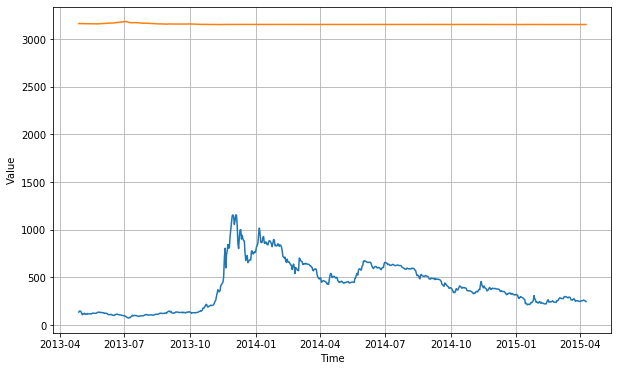

In [72]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)